In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import copy
import seaborn as sns
from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from scipy.special import digamma # ต้องติดตั้ง scipy ด้วย pip install scipy



## Function

In [ ]:
def euclidean_distance(v1, v2):
    """คำนวณ Euclidean distance ระหว่างเวกเตอร์สองตัว"""
    return np.sqrt(np.sum((v1 - v2)**2))

def maximum_norm_distance(point1, point2):
    """
    คำนวณระยะห่าง Maximum Norm (L-infinity) ระหว่างสองจุด
    นี่คือ norm ที่ใช้ใน KSG estimator
    """
    return np.max(np.abs(point1 - point2))

In [ ]:
def k_nearest_neighbors(z_space, query_point, k, norm="euclidean"):
    """
    Calculate the k-nearest neighbors of a query point in a dataset (z_space).
    Returns the k nearest data points, their indices, their distances,
    and the distance to the k-th nearest neighbor (kth_nearest_dist).
    
    Parameters:
    z_space : numpy.ndarray
        The dataset where each row is a data point (e.g., joint space (X,Y) for KSG).
        Must be a 2D numerical array (e.g., [[x1, y1_val1], [x2, y2_val2], ...]).
    query_point : numpy.ndarray
        The point for which to find the nearest neighbors.
        Must be a 1D numerical array.
    k : int
        The number of nearest neighbors to find.
    norm : str
        The norm to use for distance calculation ("euclidean" or "maximum").

    Returns:
    tuple: (data_nearest, k_nearest_indices, k_nearest_distances, kth_nearest_dist)
        data_nearest : numpy.ndarray
            The k data points closest to the query_point.
        k_nearest_indices : numpy.ndarray
            The indices of the k nearest data points in z_space.
        k_nearest_distances : list
            The distances of the k nearest data points.
        kth_nearest_dist : float
            The distance to the k-th nearest neighbor.
    """
    if k <= 0:
        raise ValueError("k must be a positive integer.")
    if k > z_space.shape[0]:
        raise ValueError(f"k ({k}) cannot be greater than the number of points in the dataset ({z_space.shape[0]}).")

    distances_with_indices = []
    
    # คำนวณระยะห่างระหว่าง query_point และทุกๆ data_point ใน z_space
    for i, data_point in enumerate(z_space):
        # ตรวจสอบว่าอินพุตเป็นตัวเลขทั้งหมดหรือไม่ (ป้องกัน object array)
        if data_point.dtype == object or query_point.dtype == object:
             raise TypeError("Input arrays must contain numerical data, not objects or nested lists.")

        if norm == "euclidean":
            dist = euclidean_distance(query_point, data_point)
        elif norm == "maximum":
            dist = maximum_norm_distance(query_point, data_point)
        else:
            raise ValueError("Unsupported norm. Use 'euclidean' or 'maximum'.")
        
        distances_with_indices.append((dist, i)) # เก็บระยะห่างและดัชนีคู่กัน
    
    # เรียงลำดับตามระยะห่างจากน้อยไปมาก
    distances_with_indices.sort(key=lambda x: x[0]) # เรียงตามระยะห่าง (x[0])
    
    # กรองจุด query_point เองออก หากระยะห่างเป็น 0 (และ query_point อยู่ใน z_space)
    # เราต้องการเพื่อนบ้าน 'k' ตัวที่ไม่ใช่ตัวมันเอง
    valid_neighbors = []
    for dist, idx in distances_with_indices:
        if dist > 0.0 or (dist == 0.0 and not np.all(query_point == z_space[idx])):
            valid_neighbors.append((dist, idx))
        if len(valid_neighbors) == k:
            break # หยุดเมื่อได้เพื่อนบ้านครบ k ตัวแล้ว
    
    if len(valid_neighbors) < k:
        # กรณีนี้อาจเกิดขึ้นถ้ามีจุดซ้ำกันมากจนหาเพื่อนบ้านไม่ครบ k ตัว
        raise ValueError(f"Could not find {k} distinct non-self neighbors for the query point. Only found {len(valid_neighbors)}.")

    # แยกข้อมูลที่ต้องการคืนค่า
    k_nearest_distances = [d for d, _ in valid_neighbors]
    k_nearest_indices = np.array([idx for _, idx in valid_neighbors])
    data_nearest = z_space[k_nearest_indices]
    
    # ระยะห่างไปยังเพื่อนบ้านลำดับที่ k คือค่าสุดท้ายในรายการ k_nearest_distances
    kth_nearest_dist = k_nearest_distances[-1]
    
    return data_nearest, k_nearest_indices, k_nearest_distances, kth_nearest_dist

In [ ]:
def ksg_mi_estimator_v1(x, y, k=5):
    """
    Estimates Mutual Information I(X;Y) using KSG Algorithm 1.
    This implementation uses the custom k_nearest_neighbors function.

    Parameters:
    x : numpy.ndarray
        Data for variable X (shape: N x dx). สามารถเป็น 1D ได้ จะถูก reshape ให้เป็น 2D
    y : numpy.ndarray
        Data for variable Y (shape: N x dy). สามารถเป็น 1D ได้ จะถูก reshape ให้เป็น 2D
    k : int, optional
        The k-nearest neighbor parameter. Default คือ 5.

    Returns:
    float
        The estimated Mutual Information I(X;Y).

    Raises:
    AssertionError: ถ้าจำนวนตัวอย่างใน X และ Y ไม่เท่ากัน
    ValueError: ถ้า k ไม่ถูกต้อง หรือข้อมูลไม่ใช่ตัวเลข
    """
    assert x.shape[0] == y.shape[0], "จำนวนตัวอย่างของ X และ Y ต้องเท่ากัน"
    N = x.shape[0]
    # k ต้องไม่เกินจำนวนตัวอย่าง-1 (เพราะเพื่อนบ้านต้องเป็นจุด 'อื่น' และ KSG ต้องมีเพื่อนบ้านอย่างน้อย k ตัว)
    assert k <= N - 1, f"k ({k}) ต้องน้อยกว่าจำนวนตัวอย่าง - 1 ({N-1}). โปรดตรวจสอบค่า k หรือขนาดข้อมูล."
    
    # ปรับรูปร่าง array 1 มิติให้เป็น 2 มิติ (column vector) เพื่อให้ concatenate ได้อย่างสอดคล้องกัน
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    # สร้างปริภูมิร่วม Z = (X, Y)
    data_joint = np.concatenate((x, y), axis=1)

    # --- ขั้นตอนที่ 1: คำนวณ epsilon(i)/2 (current_radius) สำหรับแต่ละจุด ---
    # โดยการหาระยะห่างไปยังเพื่อนบ้านลำดับที่ k ในปริภูมิร่วม (ใช้ Maximum norm เสมอสำหรับ KSG)
    radii = np.zeros(N)
    for i in range(N):
        # k_nearest_neighbors จะคืนค่า 4 อย่าง เราสนใจตัวสุดท้าย (kth_nearest_dist)
        _, _, _, kth_dist_val = k_nearest_neighbors(data_joint, data_joint[i], k, norm="maximum")
        radii[i] = kth_dist_val
    
    # --- ขั้นตอนที่ 2: นับ n_x และ n_y โดยใช้รัศมีที่กำหนด ---
    sum_digamma_nx_plus_1 = 0.0
    sum_digamma_ny_plus_1 = 0.0

    for i in range(N):
        current_radius = radii[i] # นี่คือค่า epsilon(i)/2 สำหรับจุด z_i ปัจจุบัน
        
        # นับ n_x: จำนวนจุด x_j (ในปริภูมิชายขอบ X) ที่มีระยะห่างจาก x_i น้อยกว่า current_radius อย่างเคร่งครัด
        nx_count = 0
        for j in range(N):
            if i == j: # ไม่นับจุดตัวเอง
                continue
            # ใช้ maximum_norm_distance สำหรับการนับในปริภูมิชายขอบด้วย เพื่อความสอดคล้องกับ KSG
            if maximum_norm_distance(x[i], x[j]) < current_radius: # ใช้เครื่องหมายน้อยกว่า (<) อย่างเคร่งครัด
                nx_count += 1
        
        # นับ n_y: จำนวนจุด y_j (ในปริภูมิชายขอบ Y) ที่มีระยะห่างจาก y_i น้อยกว่า current_radius อย่างเคร่งครัด
        ny_count = 0
        for j in range(N):
            if i == j: # ไม่นับจุดตัวเอง
                continue
            # ใช้ maximum_norm_distance สำหรับการนับในปริภูมิชายขอบด้วย
            if maximum_norm_distance(y[i], y[j]) < current_radius: # ใช้เครื่องหมายน้อยกว่า (<) อย่างเคร่งครัด
                ny_count += 1
        
        sum_digamma_nx_plus_1 += digamma(nx_count + 1)
        sum_digamma_ny_plus_1 += digamma(ny_count + 1)

    # --- ขั้นตอนที่ 3: คำนวณ Mutual Information ตามสูตร KSG Algorithm 1 ---
    # I(X,Y) = psi(k) - <psi(nx+1) + psi(ny+1)> + psi(N)
    mi_estimate = digamma(k) + digamma(N) - (sum_digamma_nx_plus_1 + sum_digamma_ny_plus_1) / N

    return mi_estimate


## Example

In [ ]:
# สร้างข้อมูลตัวอย่าง: N=100 จุด
n_samples = 100

# กรณีที่ 1: X และ Y มีความสัมพันธ์เชิงเส้น (ควรได้ MI สูง)
x_linear = np.random.rand(n_samples, 1) * 10 # X เป็น 1 มิติ
y_linear = 2 * x_linear + np.random.randn(n_samples, 1) # Y เป็น 1 มิติ มีความสัมพันธ์กับ X

# กรณีที่ 2: X และ Y เป็นอิสระต่อกัน (ควรได้ MI ใกล้ 0)
x_independent = np.random.rand(n_samples, 1) # X เป็น 1 มิติ
y_independent = np.random.rand(n_samples, 1) # Y เป็น 1 มิติ เป็นอิสระจาก X

# กรณีที่ 3: X เป็น 2 มิติ Y เป็น 1 มิติ (ตัวอย่างหลายมิติ)
x_multi_dim = np.random.rand(n_samples, 2) # X เป็น 2 มิติ
y_multi_dim = x_multi_dim[:, 0:1] + x_multi_dim[:, 1:2] + 0.5 * np.random.randn(n_samples, 1) # Y สัมพันธ์กับทั้งสองมิติของ X

print("--- ผลลัพธ์จากการประมาณค่า Mutual Information ด้วย KSG Estimator V1 ---")
print(f"จำนวนตัวอย่าง: {n_samples}, ค่า k: 5")

# คำนวณ MI สำหรับกรณีที่มีความสัมพันธ์
mi_linear = ksg_mi_estimator_v1(x_linear, y_linear, k=5)
print(f"MI (ความสัมพันธ์เชิงเส้น): {mi_linear:.4f}")

# คำนวณ MI สำหรับกรณีที่เป็นอิสระ
mi_independent = ksg_mi_estimator_v1(x_independent, y_independent, k=5)
print(f"MI (ตัวแปรอิสระ): {mi_independent:.4f}")

# คำนวณ MI สำหรับกรณีหลายมิติ
mi_multi_dim = ksg_mi_estimator_v1(x_multi_dim, y_multi_dim, k=5)
print(f"MI (หลายมิติ): {mi_multi_dim:.4f}")

## My Data

In [77]:
num_seeds = 30
seed = 0
# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-fullstate-rand-{i}.npz")    
    data_no_joint_pos[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_pos-rand-{i}.npz")
    data_no_joint_vel[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_joint_vel-rand-{i}.npz")
    data_no_action[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_action-rand-{i}.npz")
    data_no_imu[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_imu-rand-{i}.npz")
    data_no_fc[i] = np.load(f"data/HEBB-FULL-STATE_seed-{seed}-no_fc-rand-{i}.npz")

In [ ]:
data_fullstate[0]["action_lowpass"].reshape(data_fullstate[0]["action_lowpass"].shape[0] , -1).shape
data_fullstate[0]["state"].reshape(data_fullstate[0]["state"].shape[0] , -1).shape


In [105]:
num_seeds = 1
states = []
action_lowpass = []
for i in range(num_seeds):
    # ดึงข้อมูล 'state' และ 'action_lowpass' ออกจากแต่ละ NpzFile object
    # และ reshape ให้แน่ใจว่าเป็น 2D array (N, D)
    state_data = data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1)
    action_data = data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1)
    
    states.append(state_data)
    action_lowpass.append(action_data)
x = np.concatenate(states, axis=0)
y = np.concatenate(action_lowpass, axis=0)

In [108]:
mi_list = []
for i in range(state_data.shape[1]):
    mi_my = ksg_mi_estimator_v1(x[:,i], y, k=5)
    mi_list.append(mi_my)
print(f"MI (MY DATA): {mi_list:.4f}")

TypeError: unsupported format string passed to list.__format__

In [109]:
print(f"MI (MY DATA): {mi_list}")

MI (MY DATA): [np.float64(1.3730972101336256), np.float64(1.3161457682989557), np.float64(1.3968166714585921), np.float64(1.0656096638640982), np.float64(1.0476379117310541), np.float64(1.0943904520352534), np.float64(1.0475342211152538), np.float64(0.9074360736005609), np.float64(0.9962092759626442), np.float64(0.7727219122756779), np.float64(0.8558878007643598), np.float64(1.0479784644660342), np.float64(1.075002307132527), np.float64(1.065553141190188), np.float64(1.0523514807335026), np.float64(0.9639718645417554), np.float64(0.8977616447930172), np.float64(0.7906554883680039), np.float64(0.9876989160375205), np.float64(1.372095116747956), np.float64(1.3562290951018872), np.float64(1.4272341939350834), np.float64(1.3699360067961717), np.float64(1.3275991081693927), np.float64(1.434776046788512), np.float64(1.3484826738768687), np.float64(1.4038081419142445), np.float64(1.2751164653014975), np.float64(1.4726975992620748), np.float64(1.436373174738402), np.float64(1.3212660976175457)

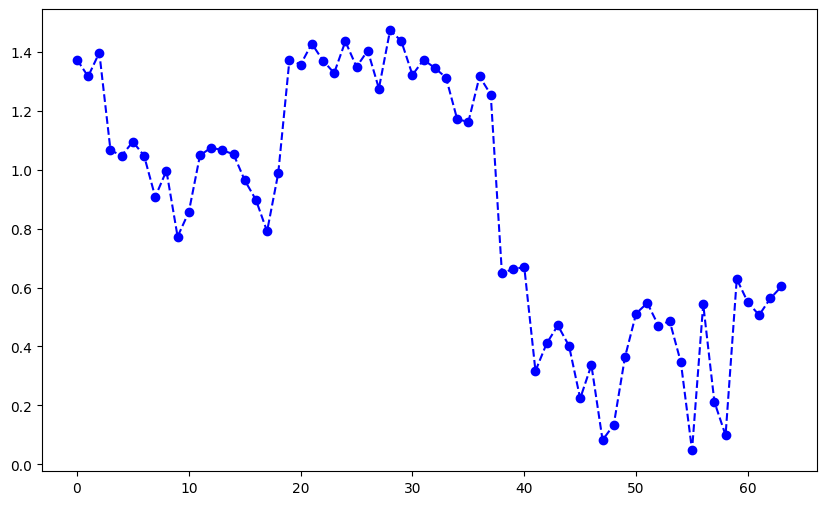

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(64) , mi_list , marker='o', linestyle='--', color='b')